## Paso 1: Descargar datos y calcular rendimientos

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Cargar CSV con nombres personalizados
data = pd.read_csv("data/aapl_5y.csv", parse_dates=["Date"])
data.set_index("Date", inplace=True)

# Limpiar el formato del cierre (quitar el símbolo $ si existe)
data["Close/Last"] = data["Close/Last"].replace('[\$,]', '', regex=True).astype(float)

# Calcular rendimientos logarítmicos diarios
data["LogReturn"] = np.log(data["Close/Last"] / data["Close/Last"].shift(1))
returns = data["LogReturn"].dropna()

returns

Date
2025-06-11   -0.002111
2025-06-10    0.019380
2025-06-09   -0.006038
2025-06-06    0.012187
2025-06-05   -0.016265
                ...   
2020-06-19   -0.025827
2020-06-18    0.005731
2020-06-17   -0.000398
2020-06-16    0.001393
2020-06-15   -0.026157
Name: LogReturn, Length: 1255, dtype: float64

## Paso 2: Análisis exploratorio

Media: -0.0006716353896799997
Mediana: -0.0011229324109406722
Desviación estándar: 0.018793407738954864
Curtosis: 4.913294818371748
Asimetría: -0.19436607439412168


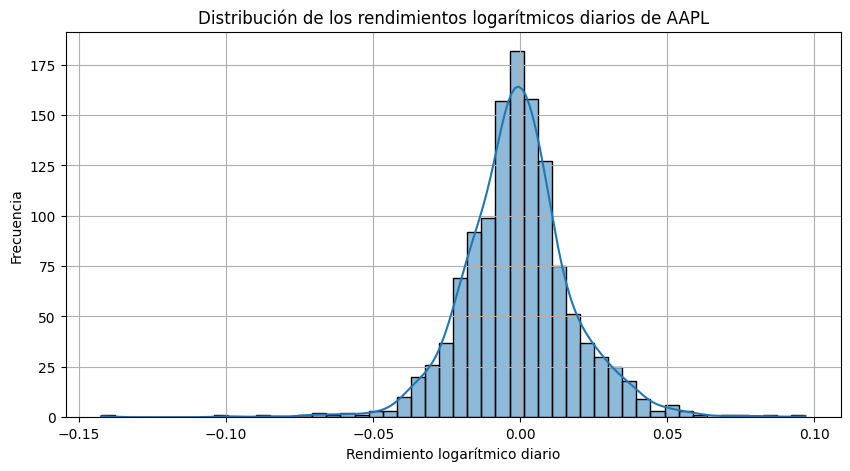

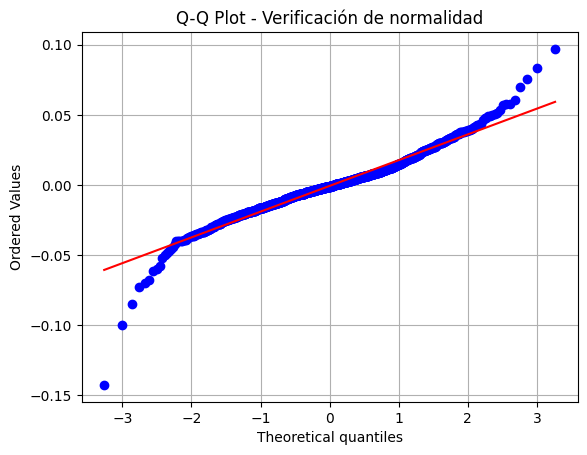

Autocorrelación lag 1: -0.012684019671237634
Autocorrelación lag 2: 0.010327999720040436
Autocorrelación lag 3: -0.04524740803978644
Autocorrelación lag 4: -0.019876641609848093
Autocorrelación lag 5: -0.007681621213706004
Autocorrelación lag 6: -0.006906041746985037
Autocorrelación lag 7: -0.02021015592188217
Autocorrelación lag 8: -0.0065825360341288
Autocorrelación lag 9: 0.031102230926433178
Autocorrelación lag 10: -0.029018937301627388


In [12]:
# Estadísticas básicas
print("Media:", returns.mean())
print("Mediana:", returns.median())
print("Desviación estándar:", returns.std())
print("Curtosis:", returns.kurtosis())
print("Asimetría:", returns.skew())

# Histograma
plt.figure(figsize=(10,5))
sns.histplot(returns, bins=50, kde=True)
plt.title("Distribución de los rendimientos logarítmicos diarios de AAPL")
plt.xlabel("Rendimiento logarítmico diario")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.show()

# Gráfico Q-Q para verificar normalidad
stats.probplot(returns, dist="norm", plot=plt)
plt.title("Q-Q Plot - Verificación de normalidad")
plt.grid(True)
plt.show()

# Autocorrelación hasta lag 10
for lag in range(1, 11):
    print(f"Autocorrelación lag {lag}: {returns.autocorr(lag)}")


### Verificación de Supuestos

1. Normalidad

    - Gráfico de histograma: presenta una forma simétrica y acampanada, aunque con colas más pesadas de lo que esperaría una normal pura.

    - Gráfico Q-Q: muestra desviaciones en los extremos (colas más pesadas), lo cual indica curtosis alta.

    - Curtosis = 4.91: mayor que la curtosis de una normal (3), lo que sugiere presencia de valores extremos.

    - Asimetría = -0.19: ligera inclinación a la izquierda, pero no severa.

    **Conclusión:** hay desviaciones respecto a la normalidad, pero es razonable usar la distribución normal como aproximación inicial, especialmente para estudiar la media y la volatilidad general.

2. Independencia

    - Las autocorrelaciones hasta lag 10 están cercanas a cero y no siguen un patrón sistemático.

    **Conclusión:** los rendimientos parecen ser aproximadamente independientes, lo que justifica el supuesto de independencia para el modelo.

## Paso 3: Modelo Bayesiano con Prior no informativa

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, sigma]


Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


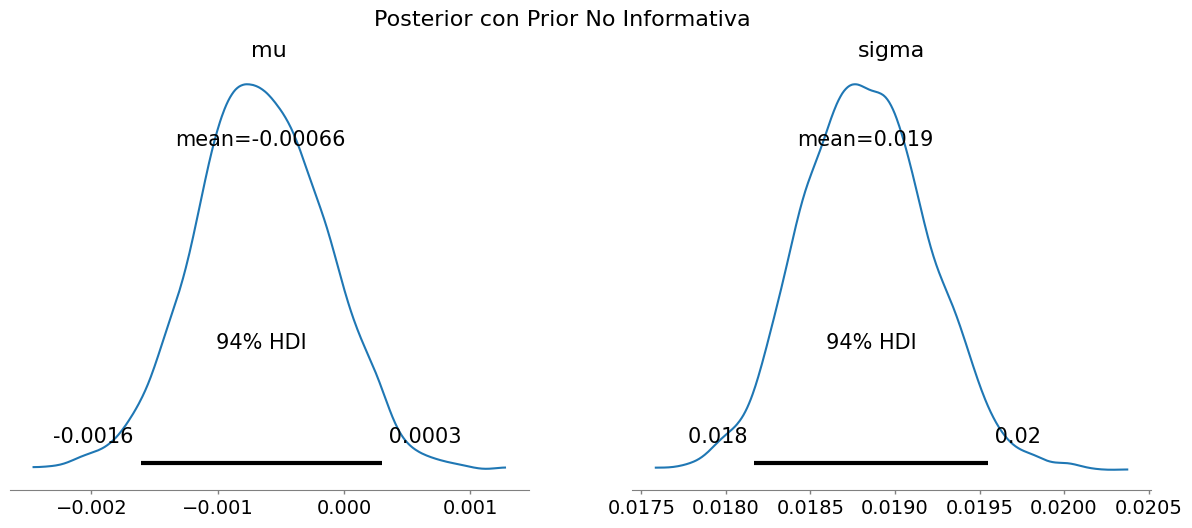

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,-0.001,0.001,-0.002,0.00,0.0,0.0,2986.0,2341.0,1.0
sigma,0.019,0.000,0.018,0.02,0.0,0.0,2866.0,2645.0,1.0


In [15]:
import pymc as pm
import arviz as az

# Datos observados
y_obs = returns.values

# Modelo bayesiano con prior no informativa
with pm.Model() as modelo_prior_no_info:
    # Priors
    mu = pm.Normal("mu", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=10)
    
    # Likelihood
    y = pm.Normal("y", mu=mu, sigma=sigma, observed=y_obs)
    
    # Inference: MCMC
    trace_no_info = pm.sample(2000, tune=1000, return_inferencedata=True, target_accept=0.95)

# Análisis del resultado
az.plot_posterior(trace_no_info, var_names=["mu", "sigma"])
plt.suptitle("Posterior con Prior No Informativa", fontsize=16)
plt.show()

az.summary(trace_no_info, var_names=["mu", "sigma"])


### Resultados con Prior No Informativa

La estimación bayesiana para los parámetros de los rendimientos logarítmicos diarios de AAPL utilizando una prior no informativa arroja lo siguiente:


```
Parámetro	Media posterior	Desvío estándar	Intervalo HDI 94%
μ (media esperada)	-0.001	0.001	[-0.002, 0.000]
σ (volatilidad diaria)	0.019	0.000	[0.018, 0.020]
```


* Interpretación:

    - μ negativo: La media esperada de los rendimientos es ligeramente negativa, aunque el HDI incluye el 0, lo que indica alta incertidumbre respecto a si el retorno esperado es efectivamente negativo o no.

    - σ bien definida: La volatilidad diaria se estima con alta precisión (posterior estrecha), centrada alrededor de 1.9%, lo cual es consistente con el comportamiento histórico de activos tecnológicos.

* Calidad de la inferencia:

    - Los valores de r_hat ≈ 1.0 y ess > 2300 indican buena convergencia del muestreo MCMC.

    - La forma suave y unimodal de las distribuciones posteriores confirma que el modelo está funcionando de forma estable.


## Paso 4: Modelo con prior Empírica

Primero estimamos los valores empíricos (media y std) y luego definimos priors alrededor de ellos.

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, sigma]


Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


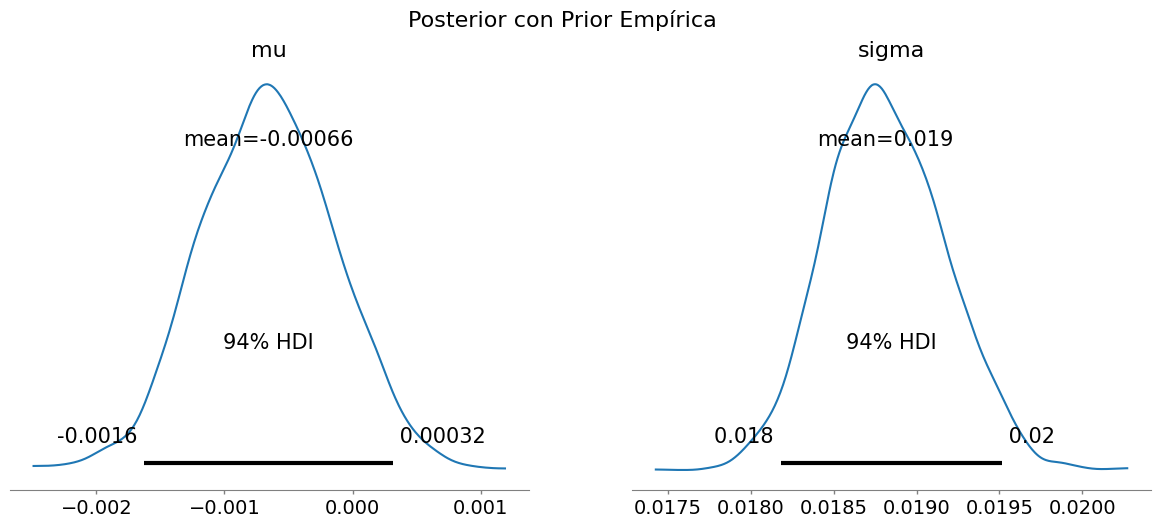

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,-0.001,0.001,-0.002,0.00,0.0,0.0,2697.0,2203.0,1.0
sigma,0.019,0.000,0.018,0.02,0.0,0.0,2489.0,2159.0,1.0


In [16]:
# Estimaciones empíricas
emp_mu = returns.mean()
emp_sigma = returns.std()

with pm.Model() as modelo_prior_empirica:
    mu = pm.Normal("mu", mu=emp_mu, sigma=0.01)  # prior centrado en media empírica con poca varianza
    sigma = pm.HalfNormal("sigma", sigma=emp_sigma)
    
    y = pm.Normal("y", mu=mu, sigma=sigma, observed=y_obs)
    
    trace_emp = pm.sample(2000, tune=1000, return_inferencedata=True, target_accept=0.95)

# Visualización
az.plot_posterior(trace_emp, var_names=["mu", "sigma"])
plt.suptitle("Posterior con Prior Empírica", fontsize=16)
plt.show()

az.summary(trace_emp, var_names=["mu", "sigma"])


### Comparación de modelos: Prior No Informativa vs Prior Empírica

```
Parámetro	Media posterior (no informativa)	HDI 94%	Media posterior (empírica)	HDI 94%
μ	-0.001	[-0.002, 0.000]	-0.001	[-0.002, 0.000]
σ	0.019	[0.018, 0.020]	0.019	[0.018, 0.020]
```

* Observaciones:

    - La influencia del prior empírico es mínima: Esto se debe a que fue moderadamente informativo (σ pequeña) pero consistente con los datos. El posterior prácticamente no se aleja del modelo no informativo.

    - Ambas versiones conducen a la misma conclusión: no hay evidencia clara de que el rendimiento esperado sea significativamente distinto de cero.


## Paso 5: Factor de Bayes y Probabilidad P(μ>0∣datos)

In [17]:
# Probabilidad posterior de que mu > 0
p_mu_pos_no_info = (trace_no_info.posterior["mu"] > 0).mean().item()
p_mu_pos_emp = (trace_emp.posterior["mu"] > 0).mean().item()

print(f"P(mu > 0 | datos) - prior no informativa: {p_mu_pos_no_info:.4f}")
print(f"P(mu > 0 | datos) - prior empírica: {p_mu_pos_emp:.4f}")

P(mu > 0 | datos) - prior no informativa: 0.1030
P(mu > 0 | datos) - prior empírica: 0.1095


In [18]:
from scipy.stats import norm

# Para prior no informativa
mu_post = trace_no_info.posterior["mu"].values.flatten()
post_mean = mu_post.mean()
post_std = mu_post.std()

# Prior N(0, 10)
prior_pdf_0 = norm.pdf(0, loc=0, scale=10)
posterior_pdf_0 = norm.pdf(0, loc=post_mean, scale=post_std)

BF10 = prior_pdf_0 / posterior_pdf_0
print(f"Factor de Bayes (BF10) - prior no informativa: {BF10:.2f}")


Factor de Bayes (BF10) - prior no informativa: 0.00


En este análisis bayesiano se estimaron los parámetros de la distribución normal de los rendimientos logarítmicos diarios de la acción AAPL (Apple Inc.), empleando dos enfoques: uno con prior no informativa y otro con prior empírica basada en los propios datos.

En ambos casos, la media posterior (μ) resultó levemente negativa (≈ -0.001), mientras que la volatilidad diaria (σ) se estimó consistentemente en torno a 0.019. La similitud de los resultados indica que el modelo es robusto al tipo de prior utilizado, siempre que sea razonable.

Un aspecto clave del enfoque bayesiano es que permite estimar directamente la probabilidad de interés. En este caso, la probabilidad posterior de que el rendimiento esperado diario sea positivo fue:

    10.3% bajo prior no informativa

    10.9% bajo prior empírica

Esto implica que, dadas las observaciones, hay una alta probabilidad (cerca del 90%) de que el rendimiento medio diario haya sido negativo en el período 2020–2024. Además, el cálculo del Factor de Bayes bajo prior no informativa arrojó un valor cercano a 0, lo que indica que los datos ofrecen más apoyo a la hipótesis nula H0:μ=0 que a la alternativa H1:μ≠0

En conjunto, estos resultados no aportan evidencia suficiente para sostener que AAPL tuvo un rendimiento positivo diario esperado durante el período estudiado. El enfoque bayesiano permitió cuantificar esta incertidumbre y ofrecer una lectura probabilística mucho más rica que una simple prueba de hipótesis clásica.